In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
def amdahl(nworkers, p):
    return 1 / (1 - p + p/nworkers)

def efficiency(nworkers, p):
    return 1 /(nworkers * (1 - p + p/nworkers))

def expfit(nworkers,offset, decay1, decay2):
    return offset - decay1 * np.exp(-nworkers* decay2)

In [21]:
data_no_bunch = np.loadtxt("Results/scaling_no_batch.out", delimiter=",")
jobID = ['63', '66', '70', '77', '79']
Data = np.zeros((63, 4, len(jobID)))
for i in range(len(jobID)):
    Data[:,:,i] = np.loadtxt("Results/slurm-1374"+jobID[i]+".out", delimiter=",")
Data[:,0,:] = Data[:,0,:] -1
data_no_bunch[:,0] = data_no_bunch[:,0] -1

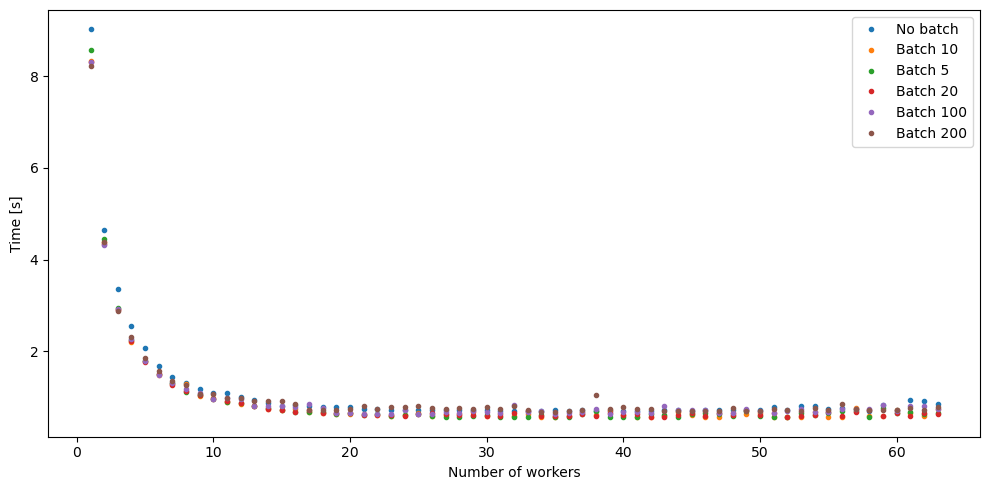

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_no_bunch[:,0], data_no_bunch[:,1], '.', label='No batch')
for i in range(len(jobID)):
    ax.plot(Data[:,0,i], Data[:,1,i], '.', label=f'Batch {int(Data[0,3,i])}')
ax.set_xlabel('Number of workers')
ax.set_ylabel('Time [s]')
ax.legend()
fig.tight_layout()

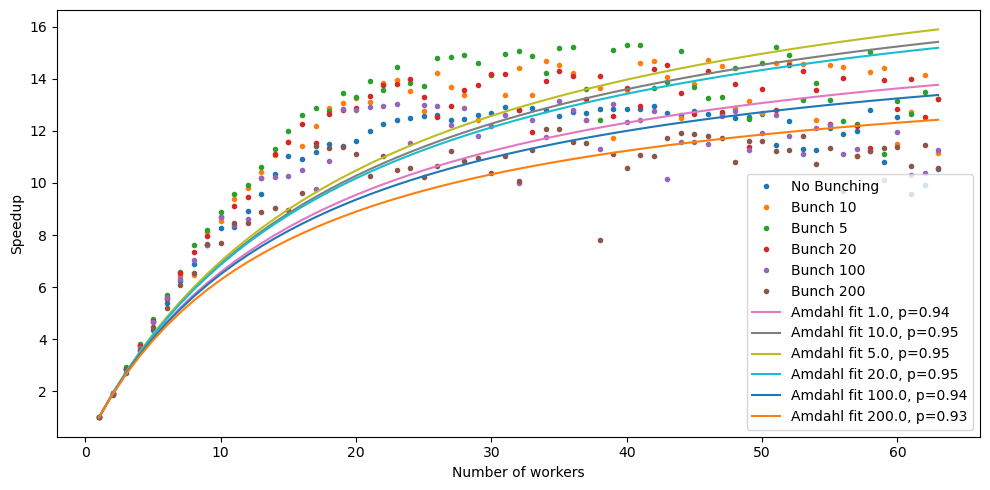

In [33]:
fitval = np.zeros(len(jobID)+1)
fit = scipy.optimize.curve_fit(amdahl, data_no_bunch[:,0], data_no_bunch[0,1]/data_no_bunch[:,1])
fitval[0] = fit[0][0]
bunch_size = np.ones(len(jobID)+1)
for i in range(len(jobID)):
    fit = scipy.optimize.curve_fit(amdahl, Data[:,0,i], Data[0,1,i]/Data[:,1,i])
    fitval[i+1] = fit[0][0]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_no_bunch[:,0], data_no_bunch[0,1]/data_no_bunch[:,1], '.', label='No Bunching')
for i in range(len(jobID)):
    ax.plot(Data[:,0,i], Data[0,1,i]/Data[:,1,i], '.', label=f'Bunch {int(Data[0,3,i])}')
    bunch_size[i+1] = int(Data[0,3,i])

for i in range(len(jobID)+1):
    ax.plot(data_no_bunch[:,0], amdahl(data_no_bunch[:,0], fitval[i]), label=f'Amdahl fit {bunch_size[i]}, p={fitval[i]:.2f}')
ax.set_xlabel('Number of workers')
ax.set_ylabel('Speedup')
ax.legend()
fig.tight_layout()